In [54]:
% cd /qbio/nest/minor/data/reference/

/qbio/nest/minor/data/reference


In [60]:
#terminal에서 grep으로 ncRNA 포함 line 추출 > ncRNAlist.txt > 그중 transcript_id만 추출 > ncRNAlist

ncRNAlist = []
import re

with open ('ncRNAlist.txt') as inpfile:
    for line in inpfile:
        element = line.split('\t')
        if element[2] == 'transcript':
            transcript_id = re.split('";|"',element[8])[3]
            if transcript_id in ncRNAlist:
                continue
            else:
                ncRNAlist.append(transcript_id)
                

In [62]:
#longest isoform
transcript_isoforms = {}
longest_isoform = []

with open ('gencode.vM25.primary_assembly.annotation.gtf') as inpfile:
    for line in inpfile:
        if line.startswith('#'):
            continue
        else:
            line = line.strip('\n')
            column = line.split('\t')
            if column[2] == 'transcript':
                length = abs(int(column[4]) - int(column[3]))
                ids = re.split('";|"',column[8])
                gene_id = ids[1]
                transcript_id = ids[3]
                if transcript_id in ncRNAlist:#non-coding RNA 제외
                    continue
                else:
                    if gene_id in transcript_isoforms:
                        transcript_isoforms[gene_id].append([transcript_id, length])
                    else:
                        transcript_isoforms[gene_id] = [[transcript_id, length]]
    for gene in transcript_isoforms: #longest isoform만 남기기 
        lists = []
        for transcript in transcript_isoforms[gene]:
            lists.append(transcript[1])
        for transcript in transcript_isoforms[gene]:
            if transcript[1] == max(lists):
                longest_isoform.append(transcript[0])
                break #만약 2개 이상 isoform의 길이가 같다면 임의로 하나만 선택하도록

In [63]:
CDS_length = {} #transcript_id:[start_codon, CDS_length]

with open ('gencode.vM25.primary_assembly.annotation.gtf') as inpfile:
    for line in inpfile:
        if line.startswith('#'):
            continue
        else:
            line = line.strip('\n')
            column = line.split('\t')
            ids = re.split('";|"',column[8])
            if column[2] == 'CDS' and ids[3] in longest_isoform: #각 longest isoform의 CDS만 추출
                    transcript_id = ids[3]
                    CDS_start = int(column[3])
                    CDS_end = int(column[4])
                    length = abs(int(column[4]) - int(column[3])) + 1
                    strand = column[6]
                    if transcript_id in CDS_length:
                        if strand == '+':
                            CDS_length[transcript_id][1] = CDS_length[transcript_id][1] + length
                            if CDS_start < CDS_length[transcript_id][0]:
                                CDS_length[transcript_id][0] = CDS_start  
                        else:# - strand
                            CDS_length[transcript_id][1] = CDS_length[transcript_id][1] + length
                            if CDS_end > CDS_length[transcript_id][0]:
                                CDS_length[transcript_id][0] = CDS_end      
                    else:
                        if strand == '+':
                            CDS_length[transcript_id] = [CDS_start, length]
                        else:# - strand
                            CDS_length[transcript_id] = [CDS_end, length]#CDS_length에는 CDSregion이 있는 isoform만 있다(거의 반이 줄어들었다)

In [64]:
Refseq = {}#transcript_id:[transcript_id, CDS_length, 5'UTR length, strand]

with open ('gencode.vM25.primary_assembly.annotation.gtf') as inpfile:
    for line in inpfile:
        if line.startswith('#'):
            continue
        else:
            line = line.strip('\n')
            column = line.split('\t')
            ids = re.split('";|"',column[8])
            if column[2] =='transcript' and ids[3] in CDS_length:
                transcript_id = ids[3]
                transcript_start = int(column[3])
                transcript_end = int(column[4])
                strand = column[6]
                #CDS_length = transcript_id:[start_codon, CDS_length]
                if strand == '+':
                    Refseq[transcript_id] = [transcript_id, CDS_length[transcript_id][1], int(CDS_length[transcript_id][0]-transcript_start+1), strand]
                else:
                    Refseq[transcript_id] = [transcript_id, CDS_length[transcript_id][1], int(abs(CDS_length[transcript_id][0]-transcript_end)+1), strand]

In [65]:
% cd /qbio/nest/minor/outcome/outcome_alignment/SAMfiles/SAM_rimoved_4,16/

/qbio/nest/minor/outcome/outcome_alignment/SAMfiles/SAM_rimoved_4,16


In [67]:
alignments={} # Qname:[transcript_id, edit_distance, POS]
single_hits = {} # alignments[Qname] 의 값 중 single_best hit만 > Qname별 하나씩
with open ('ribosomeprof_siLin28a_removed.sam') as inpfile:
    for line in inpfile:
        if line.startswith('@'): #header pass
            continue
        else:
            line = line.strip('\n')
            column = line.split('\t')
            transcript_id = column[2]
            Qname = column[0]
            POS = int(column[3]) 
            edit_distance = int(column[15].split(':')[2])#sam file의 nM값
            if transcript_id in Refseq:
            #Refseq: nonredundant Refseq transcript dictionary
            #        transcript_id:[transcript_id, CDS_length, 5'UTR length, strand(+/-)]
                if Qname in alignments:
                    alignments[Qname].append([transcript_id, edit_distance, POS])
                else:
                    alignments[Qname] = [[transcript_id, edit_distance, POS]]
    for Qname in alignments:
        if len(alignments[Qname]) == 1 and alignments[Qname][0][1] <= 1:#single alignment 된 경우&edit distancd<=1
            single_hits[Qname] = alignments[Qname][0]
        else:#multi align 된 경우
            lists = []#edit distance의 list
            for alings in alignments[Qname]:
                lists.append(aligns[1])
            if lists.count(min(lists)) == 1 and min(lists) <= 1:
                for alings in alignments[Qname]:
                    if alings[1] == min(lists):
                        single_hits[Qname] = alings
                        break

In [122]:
from collections import Counter

ribosomeprof_startcodon = [] #transcript_id:[fromstart1, fromstart2...]
ribosomeprof_stopcodon = [] #transcript_id:[fromend1, fromend2...]

for reads in single_hits:
    transcript_id = single_hits[reads][0]
    POS = single_hits[reads][2]
    #Refseq = transcript_id:[transcript_id, CDS_length, 5'UTR length, strand]
    ribosomeprof_startcodon.append(POS - Refseq[transcript_id][2])
    ribosomeprof_stopcodon.append(Refseq[transcript_id][1] - POS + Refseq[transcript_id][2] + 1)
    

startcodon = dict(Counter(ribosomeprof_startcodon))
stopcodon = dict(Counter(ribosomeprof_endcodon))

In [123]:
for line in startcodon:
    startcodon[line] = startcodon[line]/1000
for line in stopcodon:
    stopcodon[line] = stopcodon[line]/1000

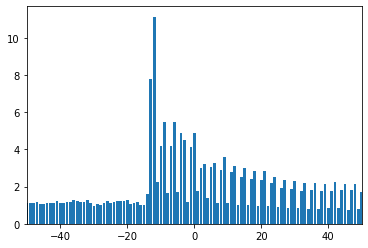

In [124]:
#그래프 그리기
import matplotlib.pyplot as plt
from collections import Counter

plt.bar(startcodon.keys(), startcodon.values())
plt.xlim(-50, 50)
plt.show()

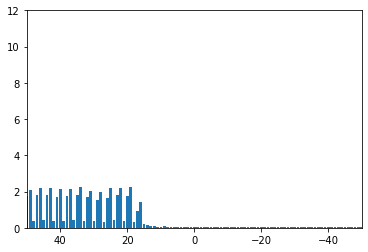

In [125]:
plt.bar(stopcodon.keys(), stopcodon.values())
plt.xlim(50, -50)
plt.ylim(0, 12)
plt.show()